**Instituto de Informática - UFG**

Disciplina: Inteligência Artificial

Prof. Cedric Luiz de Carvalho

Grupo número (   )

---


Aluna(o): 

---

Aluna(o): 

---

Aluna(o): 

---

# Especificação do problema : Árvores de Decisão

A partir da base de dados disponibilizada anteriormente, induzir uma árvore de decisão que correlacione o desempenho nos dois primeiros períodos do curso com um bom desempenho final e permita fazer previsões sobre o desempenho final de novos alunos.

Para isso, considere:


1.  Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio ou se forma com média igual ou superior a 7 ou  se forma com número de reprovações igual inferior a 5.

2. Para o treinamento do modelo, considere apenas as disciplinas dos dois primeiros períodos do curso.

3. Escolher pelo menos um dos seguintes algoritmos para a implementação: ID3, C4.5 e CART.

4. Para visualização das árvores de decisão geradas, utilize o [graphviz](https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084).


**Observação 1**: Poderão ser utilizados códigos de outros autores, desde que sejam feitos ou devidos créditos aos mesmos. Esses códigos devem ser devidamente comentados.

**Observação 2**: O trabalho deve ser feito em grupo, mas a avaliação será feita individualmente. Para isso, o grupo deverá fazer um planejamento/cronograma de trabalho e o trabalho de cada membro deverá ser devidamente identificado (por meio de** ##NomeDoAluno**)

#Procedimento


Cada membro do grupo deve assumir um dos papéis a seguir:



1.   Gerente do projeto: deve se encarregar de organizar as atividades do projeto, produzir toda a documentação do mesmo, seguindo rigorosamente o padrão definido pelo professor e fazer sua apresentação no momento apropriado.
2.   Analista de dados: deve produzir o conjunto de exemplos necessário para a implementação do modelo, bem como a sua documentação.
3. Desenvolvedor: deve implementar o modelo proposto pelo grupo, seja utilizando códigos de terceiros ou seus próprios códigos.


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import math
from collections import defaultdict
df = pd.read_csv('baseDeDados.csv', sep=';')

/home/user/.conda/envs/tcc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# " Um aluno com bom desempenho é aquele que se forma em até 4 anos e meio"

# Desconsiderar alunos que ingressaram há menos de 4 anos e meio atrás: depois de 2015.1

alunos = df[['id', 'ano_periodo_ingresso', 'data_colacao_grau', 'media_global_atual_discente']].\
rename(columns={'id': 'identificador'})

alunos['reprovacoes'] = 0

cols = ['quantidade_reprovacoes_nc', 'quantidade_reprovacoes_nl', 'quantidade_reprovacoes_neobr', 'quantidade_reprovacoes_neopt']

media_global = df[['id', 'nota_discente_componente']].\
rename(columns={'id': 'identificador'}).\
dropna().\
groupby(by=['identificador']).\
mean().\
rename(columns={'nota_discente_componente': 'media_global_calculada'})

alunos = pd.merge(alunos, media_global, how='outer', on='identificador')

alunos['media_global_considerada'] = alunos['media_global_atual_discente'].\
combine(alunos['media_global_calculada'], lambda x,y: x if not math.isnan(x) else y )

for item in cols:
     alunos['reprovacoes'] += df[item].fillna(0)

alunos['classificacao_1'] = 0
alunos['classificacao_2'] = 0
alunos['classificacao_3'] = 0
alunos['classificacao_final'] = 0

alunos = alunos[alunos['ano_periodo_ingresso'] < 2015.1 ]

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].fillna('0-0-0')

alunos['data_colacao_grau'] = alunos['data_colacao_grau'].\
apply(lambda x: int(x.split('-')[0]) + 0.1 * (int(x.split('-')[1]) < 7) + 0.2 * (int(x.split('-')[1]) > 7)  )

alunos['diff'] = alunos['data_colacao_grau'] - alunos['ano_periodo_ingresso']

alunos['classificacao_1'] = alunos['diff'].\
apply(lambda x: 1 if ( x <= 4.5 and x > 0 ) else 0)

alunos = alunos.drop_duplicates()

# se forma

alunos['formado'] = alunos['diff'].\
apply(lambda x: 1 if x > 0 else 0)

# "se forma E tem média igual ou superior a 7"

alunos['classificacao_2'] = alunos['media_global_considerada'].\
apply(lambda x: 1 if x >= 7 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# "se forma E tem número de reprovações igual inferior a 5."

alunos['classificacao_3'] = alunos['reprovacoes'].\
apply(lambda x: 1 if x <= 5 else 0 ).\
combine(alunos['formado'], lambda x,y: 1 if x & y else 0 )

# classificacao final

alunos['classificacao_final'] = alunos['classificacao_1'].\
combine(alunos['classificacao_2'], lambda x,y: 1 if x | y else 0 ).\
combine(alunos['classificacao_3'], lambda x,y: 1 if x | y else 0 )

alunos.sample(10)

,identificador,ano_periodo_ingresso,data_colacao_grau,media_global_atual_discente,reprovacoes,media_global_calculada,media_global_considerada,classificacao_1,classificacao_2,classificacao_3,classificacao_final,diff,formado
15029,435,2013.1,2017.2,6.80,9.0,6.809804,6.800000,1,0,0,1,4.1,1
9477,274,2011.1,0.1,5.50,22.0,5.623729,5.500000,0,0,0,0,-2011.0,0
10597,303,2011.2,0.1,NaN,8.0,1.750000,1.750000,0,0,0,0,-2011.1,0
15785,455,2013.2,0.1,5.20,24.0,5.228571,5.200000,0,0,0,0,-2013.1,0
14998,434,2013.1,0.1,5.69,10.0,5.690323,5.690000,0,0,0,0,-2013.0,0
10562,302,2011.2,0.1,2.86,27.0,2.714286,2.860000,0,0,0,0,-2011.1,0
7391,206,2010.2,0.1,3.54,55.0,4.014754,3.540000,0,0,0,0,-2010.1,0
458,11,2008.1,2013.2,NaN,3.0,6.344444,6.344444,0,0,1,1,5.1,1
7050,197,2010.2,0.1,NaN,23.0,4.050000,4.050000,0,0,0,0,-2010.1,0
15641,451,2013.2,0.1,3.27,13.0,3.677778,3.270000,0,0,0,0,-2013.1,0


In [4]:
# "Para o treinamento do modelo, considere apenas as disciplinas dos dois primeiros períodos do curso."

disciplinas = df[['matriz_semestre_previsto_cursar_compomente', 'nome_componente']].\
drop_duplicates().\
rename(columns={'matriz_semestre_previsto_cursar_compomente': 'semestre_previsto'})

disciplinas['num_semestre'] = disciplinas['semestre_previsto'].\
apply(lambda x: int(x.split('/')[1][0]) )

disciplinas = disciplinas[disciplinas['num_semestre'] <= 2]

# somente da grade antiga
disciplinas = disciplinas[disciplinas['semestre_previsto'].str.contains('CICOMP-BI-2')]

disciplinas

,semestre_previsto,nome_componente,num_semestre
0,CICOMP-BI-2/1-IME0073,CÁLCULO 1,1
1,CICOMP-BI-2/1-INF0131,LÓGICA MATEMÁTICA,1
2,CICOMP-BI-2/1-INF0135,MATEMÁTICA DISCRETA,1
3,CICOMP-BI-2/2-IFI0105,FÍSICA PARA COMPUTAÇÃO,2
4,CICOMP-BI-2/2-IME0006,ÁLGEBRA LINEAR,2
6,CICOMP-BI-2/2-IME0078,CÁLCULO 2,2
7,CICOMP-BI-2/2-INF0157,PROGRAMAÇÃO DE COMPUTADORES 2 CN,2
8,CICOMP-BI-2/2-INF0195,SISTEMAS DIGITAIS,2
58,CICOMP-BI-2/1-INF0109,INTRODUÇÃO À COMPUTAÇÃO,1
60,CICOMP-BI-2/1-INF0156,PROGRAMAÇÃO DE COMPUTADORES 1 CN,1


In [5]:
disciplinas = disciplinas[['nome_componente']]

identificadores = alunos[['identificador']]
notas = pd.merge(df[['id', 'nome_componente', 'nota_discente_componente']].\
                       rename(columns={'id': 'identificador'}),\
                       identificadores, how='outer', on='identificador')
# enumerar linhas repetidas
notas['componente_enum'] = notas[['identificador', 'nome_componente']].\
groupby(by=['identificador', 'nome_componente']).\
cumcount()+1

In [6]:
# Vamos descobrir:
# -- qual a média dos bons alunos que estão fazendo pela primeira vez
# -- qual a média dos bons alunos que estão fazendo pela segunda vez
# -- qual a média dos bons alunos que estão fazendo pela terceira vez
# etc. etc.

identificadores = alunos[['identificador', 'classificacao_final']]
identificadores = identificadores[identificadores['classificacao_final'] == 1][['identificador']]


medias = notas[['identificador','nome_componente','nota_discente_componente','componente_enum']]

medias = \
pd.merge(identificadores, notas, how='outer', on='identificador').\
groupby(by=['nome_componente', 'componente_enum']).\
mean().\
reset_index([0,-1]).\
rename(columns={'nota_discente_componente' : 'media'})

medias 
# Qual porcentagem de bons alunos fizeram essa matéria pela n-ésima vez?

porcentagem = pd.merge(identificadores, notas, how='outer', on='identificador').\
groupby(by=['nome_componente', 'componente_enum']).\
count().reset_index([0,-1]).\
groupby(by='nome_componente').\
transform(lambda x: x / x.max() )[['nota_discente_componente']].\
rename(columns={'nota_discente_componente' : 'porcentagem'})

bons_alunos = medias[['nome_componente', 'componente_enum']]
bons_alunos['porcentagem'] = porcentagem['porcentagem']
bons_alunos['media'] = medias['media']
bons_alunos.head()

/home/user/.conda/envs/tcc/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,nome_componente,componente_enum,porcentagem,media
0,ALGORITMOS E ESTRUTURAS DE DADOS 1,1,1.000000,6.612766
1,ALGORITMOS E ESTRUTURAS DE DADOS 1,2,0.085106,5.950000
2,ALGORITMOS E ESTRUTURAS DE DADOS 2,1,1.000000,5.973333
3,ANÁLISE E PROJETO DE ALGORITMOS,1,1.000000,4.424242
4,ANÁLISE E PROJETO DE ALGORITMOS,2,0.367003,3.770642


In [406]:
# Para cada par (matéria, aluno) devemos:
# -- Atribuir um score que é a porcentagem de bons alunos na última repetição da matéria
# -- Atribuir o desvio da nota do aluno em relação à média dos bons alunos naquela repetição
# -- Atribuir 0 ( se for mau aluno) ou 1 ( se for bom aluno )
# ( repetições sem bons alunos são desconsideradas )
# esses atributos serão fornecidos à árvore de decisão

notas.head()

,identificador,nome_componente,nota_discente_componente,componente_enum
0,1,CÁLCULO 1,7.3,1
1,1,LÓGICA MATEMÁTICA,6.8,1
2,1,MATEMÁTICA DISCRETA,5.0,1
3,1,FÍSICA PARA COMPUTAÇÃO,5.0,1
4,1,ÁLGEBRA LINEAR,4.2,1


In [41]:
dados_finais = notas[['identificador', 'nome_componente', 'nota_discente_componente', 'componente_enum']]
dados_finais = pd.merge(dados_finais, disciplinas[['nome_componente']], how='inner', on='nome_componente')
dados_finais = pd.merge(dados_finais, bons_alunos, how='outer', on=['nome_componente', 'componente_enum']).\
sort_values(by=['identificador', 'nome_componente'])
dados_finais['desvio'] = dados_finais['nota_discente_componente'] - dados_finais['media']
dados_finais['desvio'] += 10
dados_finais['desvio'] /= 20

#dados_finais['porcentagem'].isna().sum()

dados_finais['porcentagem_cumulativa'] = dados_finais['porcentagem']
dados_finais['porcentagem_parcial'] = dados_finais\
.groupby(by=['identificador', 'nome_componente'])['porcentagem']\
.diff(periods=-1)

dados_finais['porcentagem'] = dados_finais['porcentagem_parcial']\
.combine_first(dados_finais['porcentagem_cumulativa'])

def media_ponderada(grupo, nome, peso):
    n = grupo[nome]
    p = grupo[peso]
    return (n * p).sum() / p.sum()

mp = dados_finais.\
groupby(by=['identificador', 'nome_componente']).\
apply(media_ponderada,'desvio','porcentagem').\
reset_index([0,-1]).\
rename(columns={0: 'media_ponderada'})

porcentagem_minima = dados_finais[['identificador', \
                                   'nome_componente', \
                                   'porcentagem']].\
groupby(by=['identificador', 'nome_componente']).\
apply(lambda x: x.min())[['porcentagem']].\
reset_index().\
rename(columns={"porcentagem" : "porcentagem_minima"})

dados_finais = pd.merge(mp, dados_finais, how='outer', on=['identificador', 'nome_componente'])
dados_finais = pd.merge(porcentagem_minima, dados_finais, how='outer', on=['identificador', 'nome_componente'])

In [42]:
# verificar valores vazios / desconhecidos 

check_disc = [ x['nome_componente'] for x in list(disciplinas.T.to_dict().values()) ]

check_ids = [ x['identificador'] for x in list(dados_finais.T.to_dict().values())]

check_ids = [ v for i,v in enumerate(check_ids) if check_ids.index(v) == i ]

table = []
for idx in check_ids:
    for d in check_disc:
        row = {}
        row['identificador'] = idx
        row['nome_componente'] = d
        table.append(row)

print(dados_finais.shape)
resultado = pd.merge( pd.DataFrame(table), \
                     dados_finais, \
                     how='outer', \
                     on=['identificador', 'nome_componente']).\
sort_values(by=['identificador', 'nome_componente'])

# # colocar a classificação como coluna

resultado = \
pd.merge(resultado, alunos[['identificador', \
                            'classificacao_final']], \
         how='inner', \
         on='identificador')\
.sort_values(by=['identificador', 'nome_componente'])

print(resultado.shape)
resultado.head()

(7152, 11)
(6945, 12)


,identificador,nome_componente,porcentagem_minima,media_ponderada,nota_discente_componente,componente_enum,porcentagem,media,desvio,porcentagem_cumulativa,porcentagem_parcial,classificacao_final
0,1.0,CÁLCULO 1,1.0,0.677719,7.3,1.0,1.0,3.745614,0.677719,1.0,NaN,0
1,1.0,CÁLCULO 2,1.0,0.573474,5.2,1.0,1.0,3.730523,0.573474,1.0,NaN,0
2,1.0,FÍSICA PARA COMPUTAÇÃO,1.0,0.541128,5.0,1.0,1.0,4.177434,0.541128,1.0,NaN,0
3,1.0,INTRODUÇÃO À COMPUTAÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1.0,LÓGICA MATEMÁTICA,1.0,0.618267,6.8,1.0,1.0,4.434656,0.618267,1.0,NaN,0


In [92]:
lista_porcentagem = list(resultado['porcentagem_minima'])
lista_desvio = list(resultado['media_ponderada'])

lista_porcentagem = [ lista_porcentagem[i:i+10] for i in range(0,len(lista_porcentagem),10) ]
lista_desvio = [ lista_desvio[i:i+10] for i in range(0,len(lista_desvio),10) ]

lista_classificacao = list(resultado['classificacao_final'])
lista_classificacao = [ lista_classificacao[i] for i in range(0,len(lista_classificacao),10) ]

assert( len(lista_desvio) == len(lista_porcentagem) == len(lista_classificacao))

features = []
for i,v in enumerate(lista_porcentagem):
    row = []
    row.extend(lista_porcentagem[i])
    row.extend(lista_desvio[i])
    features.append(row)
    
for idx,item in enumerate(features):
    item.append(lista_classificacao[idx])

<IPython.core.display.Javascript object>


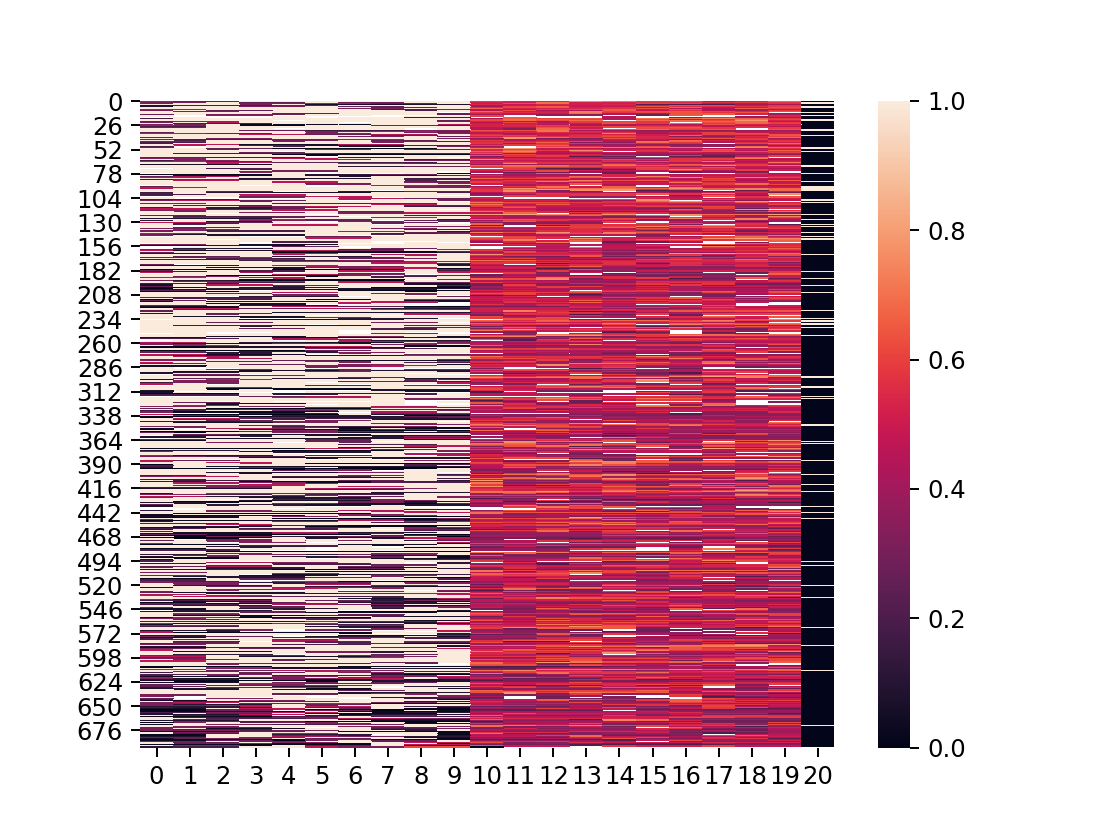

In [45]:
%matplotlib notebook
sns.heatmap(pd.DataFrame(features))

In [47]:
pd.DataFrame(features).to_csv('dataset.csv', index=False)

<IPython.core.display.Javascript object>


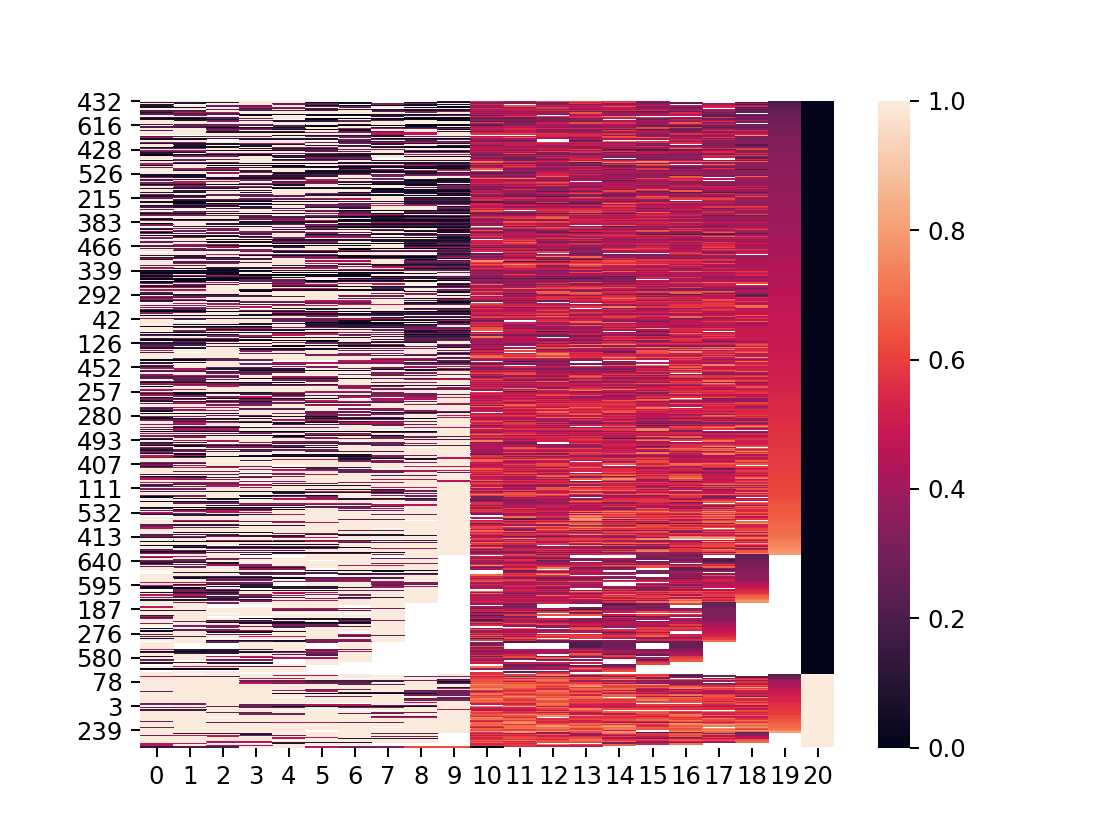

In [48]:
%matplotlib notebook
sort_array = [ item for sublist in [ (x, x+10) for x in range(0,10)] for item in sublist ][::-1]
sort_array.insert(0,20)
sns.heatmap(pd.DataFrame(features).sort_values(by=sort_array))

<IPython.core.display.Javascript object>


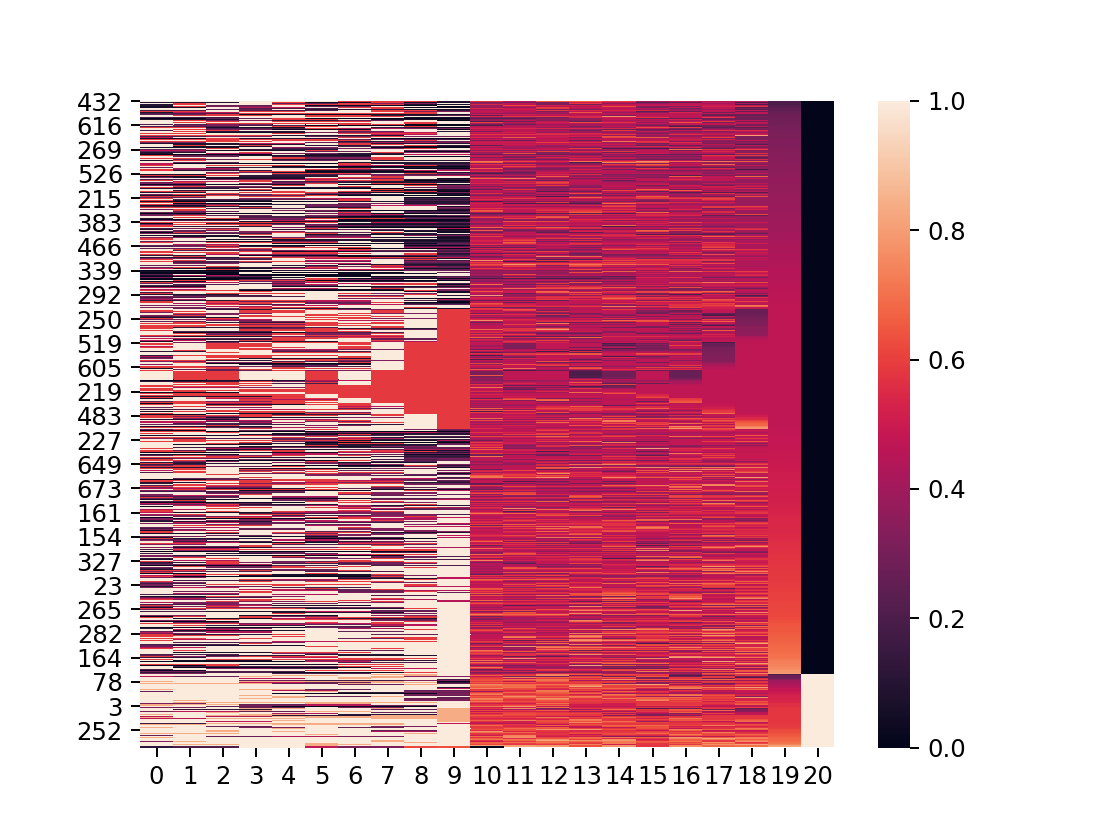

In [93]:
nan_values = []
for i,v in enumerate(features):
    for j,k in enumerate(v):
        if math.isnan(features[i][j]):
            nan_values.append((i,j, features[i][-1]))
    
good_student_prob = []
bad_student_prob = []
good_student_grade = []
bad_student_grade = []
for i,v in enumerate(features):
    for j,k in enumerate(v[0:-1]):
        if features[i][-1] == 0:
            if j < 10:
                bad_student_prob.append(features[i][j])
            else:
                bad_student_grade.append(features[i][j])
        elif features[i][-1] == 1:
            if j < 10:
                good_student_prob.append(features[i][j])
            else:
                good_student_grade.append(features[i][j])
                
remove_nan = lambda x: [z for z in x if not math.isnan(z)]
good_student_prob_mean = np.mean(remove_nan(good_student_prob))
bad_student_prob_mean = np.mean(remove_nan(bad_student_prob))
good_student_grade_mean = np.mean(remove_nan(good_student_grade))
bad_student_grade_mean = np.mean(remove_nan(bad_student_grade))

for i,v in enumerate(features):
    for j,k in enumerate(v[0:-1]):
        if features[i][-1] == 0:
            if j < 10 and math.isnan(features[i][j]):
                features[i][j] = bad_student_prob_mean
            elif math.isnan(features[i][j]):
                features[i][j] = bad_student_grade_mean
        elif features[i][-1] == 1:
            if j < 10 and math.isnan(features[i][j]):
                features[i][j] = good_student_prob_mean
            elif math.isnan(features[i][j]):
                features[i][j] = good_student_grade_mean
                
sort_array = [ item for sublist in [ (x, x+10) for x in range(0,10)] for item in sublist ][::-1]
sort_array.insert(0,20)
sns.heatmap(pd.DataFrame(features).sort_values(by=sort_array))

In [99]:
pd.DataFrame(features).dropna().to_csv('dataset_preenchido.csv', index=False)

In [118]:
tree_input = pd.DataFrame(features).dropna().values.tolist()

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import random

X = [ x[0:-1] for x in tree_input ]
y = [ x[-1] for x in tree_input ]

rdlist = list(zip(X,y))
random.shuffle(rdlist)

X = [ x[0] for x in rdlist ]
y = [ x[1] for x in rdlist ]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)
y_pred = clf_gini.predict(X_test)

print("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  90.80459770114942
